In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv('train.csv', sep='\t')
df_test = pd.read_csv('test.csv', sep='\t')

In [3]:
from bs4 import BeautifulSoup 
from datetime import datetime
import re, time
import pymorphy2

cachedDict = dict()
morph = pymorphy2.MorphAnalyzer()

def cleanText(text):
    res = BeautifulSoup(text, "html5lib").get_text()
    res = re.sub('[^а-яёА-ЯЁa-zA-Z ]', ' ', res)
    return res.lower()

def parseMorph(text, cached=True):
    resultList = []
    wordList = re.findall('[А-Яа-яЁё]+\-[А-Яа-яЁё]+|[А-Яа-яЁё]+', text)
    for word in wordList:

        if cached & (word in cachedDict):
            resultList.append(cachedDict[word])
        else:
            pv = morph.parse(word)
            for p in pv:
                if p.tag.POS in ['ADJF', 'NOUN', 'VERB']:
                    resultList.append(p.normal_form)
                    if cached:
                        cachedDict[word] = p.normal_form
                    break
    return resultList

def preproc_data(df_input):
    df_output = df_input.copy()
    
    print('\nJoin titles and advert texts')
    df_output['text'] = df_output['name'] + ' ' + df_output['description']

    print('\nClean the text')
    df_output['text'] = df_output['text'].map(cleanText)

    print('\nUse Pymorphy2')
    df_output['text_morph'] = df_output['text'].map(parseMorph)
    df_output['text_morph_str'] = df_output['text_morph'].map(lambda x: ' '.join(x))
        
    return df_output

In [4]:
%%time
# распарсим данные
df_train_preproc= preproc_data(df_train)
df_test_preproc= preproc_data(df_test)


Join titles and advert texts

Clean the text

Use Pymorphy2

Join titles and advert texts

Clean the text

Use Pymorphy2
CPU times: user 42min 9s, sys: 10.6 s, total: 42min 19s
Wall time: 42min 24s


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
#Просто текст невекторизованный
X = df_train_preproc['text']
y = df_train_preproc['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [15]:
%%time
cv = CountVectorizer(ngram_range = (1,2))

model_LR_CV = Pipeline([ ('cv', cv), ('lr', LogisticRegression()) ])
model_LR_CV.fit(X_train, y_train)

predict_LR_CV = model_LR_CV.predict(X_test)
predict_proba_LR_CV = model_LR_CV.predict_proba(X_test)

print(classification_report(y_test, predict_LR_CV))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97     32011
          1       0.96      0.97      0.97     27989

avg / total       0.97      0.97      0.97     60000

CPU times: user 16min 31s, sys: 44 s, total: 17min 15s
Wall time: 9min 28s


In [19]:
#Используем подготовленный pymorphy2 текст
X = df_train_preproc['text_morph_str']
y = df_train_preproc['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [20]:
%%time
cv = CountVectorizer(ngram_range = (1,2))

model_LR_CV_M = Pipeline([ ('cv', cv), ('lr', LogisticRegression()) ])
model_LR_CV_M.fit(X_train, y_train)

predict_LR_CV_M = model_LR_CV_M.predict(X_test)
predict_proba_LR_CV_M = model_LR_CV_M.predict_proba(X_test)

print(classification_report(y_test, predict_LR_CV_M))

             precision    recall  f1-score   support

          0       0.97      0.96      0.97     32011
          1       0.96      0.96      0.96     27989

avg / total       0.96      0.96      0.96     60000

CPU times: user 10min 25s, sys: 22.5 s, total: 10min 48s
Wall time: 4min 59s


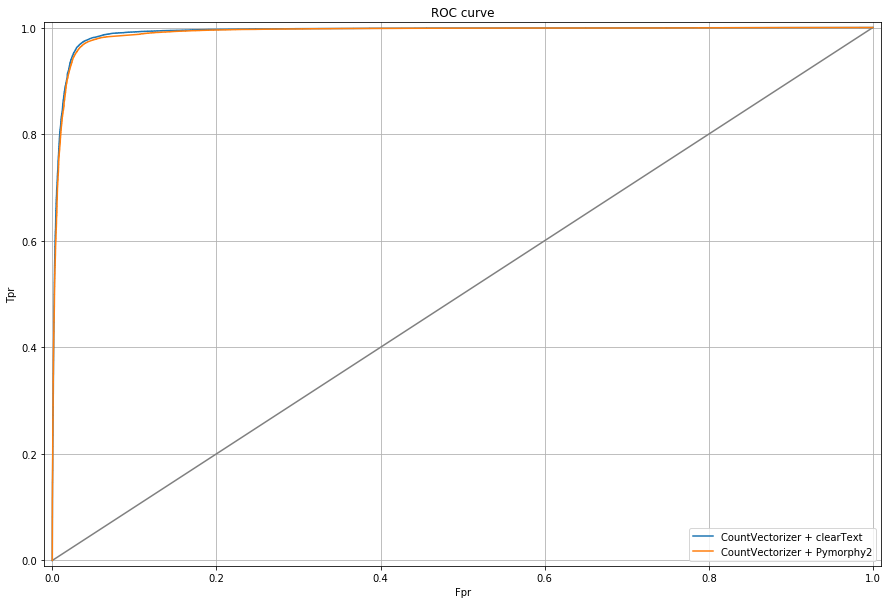

ROC_AUC
LogisticRegression w/ clearText		 0.9917977981145654
LogisticRegression w/ Pymorphy2		 0.9906379072936471


In [22]:
# визуально посмотрим на точность классификатора
Fpr_LR_CV, Tpr_LR_CV, thresholds = roc_curve(y_test, predict_proba_LR_CV[:,1])
Fpr_LR_CV_M, Tpr_LR_CV_M, thresholds = roc_curve(y_test, predict_proba_LR_CV_M[:,1])

plt.figure(figsize=(15, 10))
plt.plot([0, 1], [0, 1], 'grey')

plt.ylabel('Tpr')
plt.xlabel('Fpr')

plt.title('ROC curve')
plt.grid(True)

plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))


plt.plot(Fpr_LR_CV, Tpr_LR_CV, label='CountVectorizer + clearText')
plt.plot(Fpr_LR_CV_M, Tpr_LR_CV_M, label='CountVectorizer + Pymorphy2')

plt.legend()
plt.show()

print('ROC_AUC')
print('LogisticRegression w/ clearText\t\t', roc_auc_score(y_test, predict_proba_LR_CV[:,1]))
print('LogisticRegression w/ Pymorphy2\t\t', roc_auc_score(y_test, predict_proba_LR_CV_M[:,1]))

In [23]:
# предсказание и сохранение результатов
result_predict = model_LR_CV.predict(df_test_preproc['text'])

df_result = pd.DataFrame(data = {'id':df_test_preproc['id'],'target':result_predict})
df_result.to_csv('result_submission2.csv', sep=',', index=False) # по уму надо бы проверять - а создался ли файл
df_result.head()

,id,target
0,200000,1
1,200001,1
2,200002,1
3,200003,1
4,200004,0
